In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TRAIN_FILE_PATH = 'data/sentence-relations/train.csv'
TEST_FILE_PATH = 'data/sentence-relations/test.csv'

train_df = pd.read_csv(TRAIN_FILE_PATH)
test_df = pd.read_csv(TEST_FILE_PATH)

INDEX_TO_LABEL = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
LABEL_TO_INDEX = {v: k for k, v in INDEX_TO_LABEL.items()}

np.random.seed(0)

In [2]:
train_df['label_readable'] = train_df['label'].apply(lambda x: INDEX_TO_LABEL[int(x)])
train_df.head()

,id,premise,hypothesis,lang_abv,language,label,label_readable
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,entailment
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,contradiction
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0,entailment
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,entailment
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1,neutral


Text(0, 0.5, 'Count')

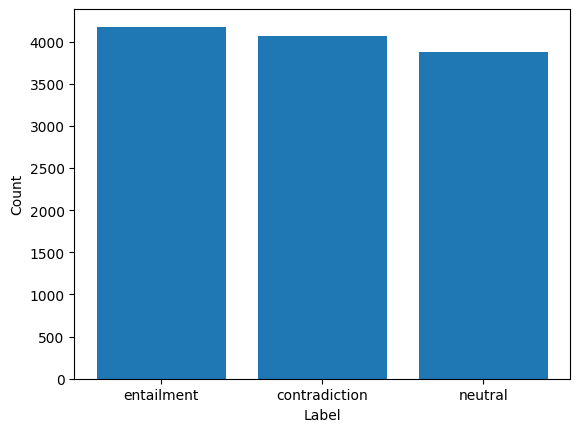

In [3]:
plt.bar(train_df['label_readable'].value_counts().index, train_df['label_readable'].value_counts().values)
plt.xlabel('Label')
plt.ylabel('Count')

<BarContainer object of 15 artists>

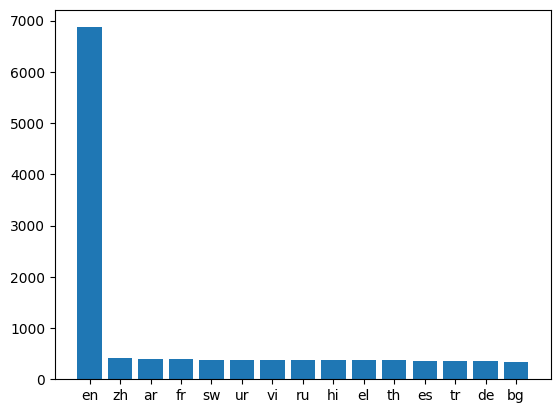

In [4]:
plt.bar(train_df['lang_abv'].value_counts().index, train_df['lang_abv'].value_counts().values)

In [5]:
def filter_language(df, lang_abv):
    return df[df['lang_abv'] == lang_abv].dropna().reset_index(drop=True)

def display_example(df, idx):
    print('Lang:', df['lang_abv'][idx])
    print('Premise:', df['premise'][idx])
    print('Hypothesis:', df['hypothesis'][idx])
    print('Label:', INDEX_TO_LABEL[df['label'][idx]])
    print("")

train_german_df = filter_language(train_df, 'de')
train_english_df = filter_language(train_df, 'en')

display_example(train_german_df, 20)
display_example(train_german_df, 100)
display_example(train_german_df, 101)

Lang: de
Premise: Analyse der FAA-Flugverkehrskontrolldaten durch die Kommission.
Hypothesis: Die Luftverkehrskontrolldaten der FAA wurden nie untersucht.
Label: contradiction

Lang: de
Premise: In Indianapolis gibt es eine große Auswahl an Kunst- und Kulturangeboten, jedoch ist keines besser als das Civic Theatre.
Hypothesis: Das Bürgertheater ist in Indianapolis.
Label: entailment

Lang: de
Premise: Der Plan ist der Generator predigte Le Corbusier, aber bei Gehry war der Plan das Ergebnis.
Hypothesis: Der Plan ist, ein Land zu erobern.
Label: neutral



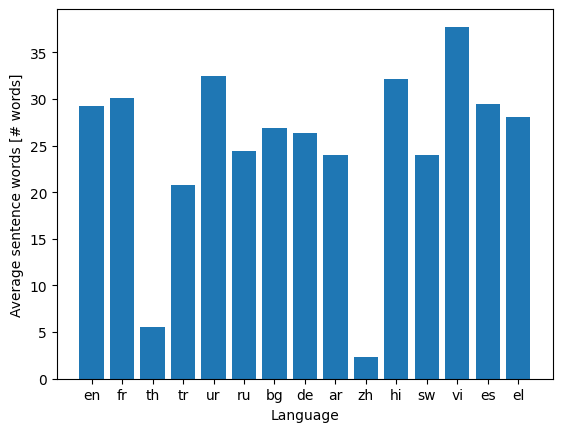

In [6]:
def plot_average_sentence_length_per_language(df):
    unique_langs = df['lang_abv'].unique()
    avg_sentence_lengths = {}

    for lang in unique_langs:
        lang_df = filter_language(df, lang)

        avg_length = 0
        for i in range(len(lang_df)):
            avg_length += len(lang_df['premise'][i].split()) + len(lang_df['hypothesis'][i].split())
        avg_length /= len(lang_df)

        avg_sentence_lengths[lang] = avg_length

    plt.bar(avg_sentence_lengths.keys(), avg_sentence_lengths.values())
    plt.xlabel('Language')
    plt.ylabel('Average sentence words [# words]')

plot_average_sentence_length_per_language(train_df)

In [7]:
def get_max_token_length(df):
    max_length = 0
    for i in range(len(df)):
        max_length = max(max_length, len(df['premise'][i].split()), len(df['hypothesis'][i].split()))
    return max_length

def preprocess_dataset(df):
    max_length = get_max_token_length(df)
    print('Max token length:', max_length)

    token_arr = []

    for i in range(len(df)):
        tokens1 = df['premise'][i].split()
        tokens2 = df['hypothesis'][i].split()

        # Fill with padding
        tokens1 += [''] * (max_length - len(tokens1))
        tokens2 += [''] * (max_length - len(tokens2))

        token_arr.append((tokens1, tokens2))

    # Convert to numpy array
    token_arr = np.array(token_arr)

    return token_arr

train_dataset_english = preprocess_dataset(train_english_df)

Max token length: 196


In [14]:
def get_token_occurence(dataset):
    token_occurence = {}

    for i in range(dataset.shape[0]):
        for j in range(dataset.shape[1]):
            for token in dataset[i][j]:
                if token not in token_occurence:
                    token_occurence[token] = 0
                token_occurence[token] += 1
    token_occurence.pop('')  # Remove padding token

    return token_occurence

def sort_tokens_by_occurence(occurence):
    sorted_tokens = sorted(occurence.items(), key=lambda x: x[1], reverse=True)
    # sorted_tokens_dict = {k: v for k, v in sorted_tokens}
    return sorted_tokens


token_occurence = sort_tokens_by_occurence(get_token_occurence(train_dataset_english))
print('Number of unique tokens:', len(token_occurence))

Number of unique tokens: 20617


In [15]:
token_occurence[0:10]

[('the', 10160),
 ('of', 5489),
 ('to', 5335),
 ('and', 4969),
 ('a', 4096),
 ('in', 3091),
 ('is', 2429),
 ('The', 2301),
 ('that', 2294),
 ('for', 1756)]

In [22]:
# Map token occurence to different labels
def get_relation_between_token_and_label(dataframe, token_occurence):

    token_label_relation = {}

    for token, occurence in token_occurence:
        token_label_occurence = {0: 0, 1: 0, 2: 0}
        token_label_relation[token] = token_label_occurence

    for entry in dataframe.iterrows():
        premise = entry[1]['premise'].split()
        hypothesis = entry[1]['hypothesis'].split()

        for token in premise + hypothesis:
            if token in token_label_relation:
                token_label_relation[token][entry[1]['label']] += 1

    return token_label_relation

relations = get_relation_between_token_and_label(train_english_df, token_occurence)

In [42]:
def get_keywords_for_label(relations, label, threshold=1.15):

    keywords = []

    for token, occurence in relations.items():
        avg_occurence = sum(occurence.values()) / len(occurence)

        if sum(occurence.values()) < 100:
            continue

        if occurence[label] > avg_occurence * threshold:
            print('Token:', token, 'Occurence:', occurence, 'Avg:', avg_occurence)
            keywords.append(token)

    return keywords

keywords_0 = get_keywords_for_label(relations, 0)
keywords_1 = get_keywords_for_label(relations, 1)
keywords_2 = get_keywords_for_label(relations, 2)

Token: by Occurence: {0: 306, 1: 218, 2: 238} Avg: 254.0
Token: can Occurence: {0: 213, 1: 162, 2: 163} Avg: 179.33333333333334
Token: In Occurence: {0: 94, 1: 75, 2: 74} Avg: 81.0
Token: A Occurence: {0: 92, 1: 69, 2: 74} Avg: 78.33333333333333
Token: said Occurence: {0: 77, 1: 55, 2: 68} Avg: 66.66666666666667
Token: where Occurence: {0: 74, 1: 49, 2: 70} Avg: 64.33333333333333
Token: after Occurence: {0: 72, 1: 55, 2: 58} Avg: 61.666666666666664
Token: This Occurence: {0: 75, 1: 52, 2: 57} Avg: 61.333333333333336
Token: through Occurence: {0: 69, 1: 53, 2: 49} Avg: 57.0
Token: information Occurence: {0: 58, 1: 46, 2: 33} Avg: 45.666666666666664
Token: year Occurence: {0: 51, 1: 39, 2: 41} Avg: 43.666666666666664
Token: If Occurence: {0: 47, 1: 44, 2: 29} Avg: 40.0
Token: small Occurence: {0: 44, 1: 42, 2: 28} Avg: 38.0
Token: might Occurence: {0: 46, 1: 39, 2: 27} Avg: 37.333333333333336
Token: being Occurence: {0: 45, 1: 32, 2: 32} Avg: 36.333333333333336
Token: legal Occurence: {0

In [45]:
def classify_using_keywords(df, keywords_0, keywords_1, keywords_2):
    classifications = []

    for i in range(len(df)):
        premise = df['premise'][i].split()
        hypothesis = df['hypothesis'][i].split()

        score = [0, 0, 0]

        for token in premise + hypothesis:
            if token in keywords_0:
                score[0] += 1
            if token in keywords_1:
                score[1] += 1
            if token in keywords_2:
                score[2] += 1

        classifications.append(np.argmax(score))

    return classifications

def evaluate_classification(df, classifications):
    correct = 0

    for i in range(len(df)):
        if classifications[i] == df['label'][i]:
            correct += 1

    return correct / len(df)

classifications = classify_using_keywords(train_english_df, keywords_0, keywords_1, keywords_2)
accuracy = evaluate_classification(train_english_df, classifications)

print('Accuracy:', accuracy)

Accuracy: 0.41441048034934497


In [ ]:
def generate_submission_file(raw_df):
    # Get time as yyyy-mm-dd-hh-mm-ss
    time_str      = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())
    file_path     = "data/sentence-relations/submission_{}.csv".format(time_str)
    submission_df = pd.DataFrame({
        'id': raw_df['id'],
        'predictions': raw_df['predictions']
    })
    submission_df.to_csv(file_path, index=False)
    print(f'Saved submission file to {file_path}')